In [43]:
# basic set of imports
import re, operator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import cross_validation
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler

from IPython.display import display, HTML
import datetime, pickle
import time
import tables
import csv
%matplotlib inline

In [44]:
datasets = ["test","train"]

In [49]:
# parser functions
# dateutil.parser.parse(timestr, parserinfo=None, **kwargs)
# Returns a datetime.datetime object or, if the fuzzy_with_tokens option is True, returns a tuple, the first element being a datetime.datetime object, the second a tuple containing the fuzzy tokens.

def custom_parser(timestr):
    
    try:
        out = pd.to_datetime(timestr)
    except ValueError: # maybe just the year is garbled?
        try:
            special_year = ['1980']
            special_year.extend(timestr.split("-")[1:3])
            out = pd.to_datetime( "-".join(special_year) )
        except ValueError: # nope - all garbled
            out = np.datetime64('NaT')
        
# if there's a parse error
#    try replacing the year with "1980-" and parsing that
#    if that still fails, then return NaT    
    
    return out


In [52]:
missing_date_values = []

num_types = ['uint8', 'int8', 'uint16', 'int16', 'uint32', 'int32', 'uint64', 'int64','float32', 'float64','object']
# 'bool' - rhdf5 has problems translating bools from hdf5 files

dtypes_dict = dict()
# keys = col, values = (0 if type initially int64, 9 if type initially float64, 11 if type initially O)
init_type = {np.dtype('int64'):num_types.index('uint8'),
             np.dtype('float64'):num_types.index('float32'),
             np.dtype('object'):num_types.index('object')}

datetime_col_errors_dict = dict()

datetime_col_errors_tup = dict()

for dataset in datasets: #
    
    csv_chunks = pd.read_csv(r"..\expedia_data\{0}.csv".format(dataset), chunksize=500000 )
    count =0
    for chunk in csv_chunks:
        
        count +=1
        print( "dataset:{0} chunk:{1} ".format(dataset,count) )
        for col in chunk.columns:

            if col not in dtypes_dict.keys():
                dtypes_dict[col] = init_type[ chunk[col].dtype ]

            # float64 and int 64
            if chunk[col].dtype in [np.dtype('int64'),np.dtype('float64')]:
                a = False
                while(dtypes_dict[col]<11 and a==False):

                    a = all( chunk[ col ].dropna().astype( num_types[ dtypes_dict[col] ] )==chunk[ col ].dropna() )
                    if a==False:
                        dtypes_dict[col] += 1
            # object - all assumed to be datetime
            elif chunk[col].dtype == np.dtype('object'):
                
                
                # faster to go through the entire thing looking for issues ... or to try to convert
                try:
                    pd.to_datetime(chunk[col])
                except ValueError:
                    chunk_pos = 0
                    for el in chunk[col]: # check every element in the offending column!
                        try:
                            pd.to_datetime(el)
                        except ValueError:
                            # add value to DataFrame - id, col, value
    #                         if no_datetime_errors_found == True:
    #                             datetime_col_errors = pd.DataFrame( [el.index[0],col,el] )
    #                             datetime_col_errors.columns=('id','column','value')

                            tup = ( chunk.iloc[chunk_pos]["srch_ci"], chunk.iloc[chunk_pos]["srch_co"] )
                            row_id = 1 ### place holder!
    #                             no_datetime_errors_found = False:
    #                         else:
    #                             datetime_col_errors.loc[len(datetime_col_errors)] = [el.index[0],col,el]  

                            if col not in datetime_col_errors_dict.keys():
                                datetime_col_errors_dict[col] = [ el ]
                            else:
                                if el not in datetime_col_errors_dict[col]:
                                    datetime_col_errors_dict[col].append( el )    
    
                            if tup not in datetime_col_errors_tup.keys():
                                datetime_col_errors_tup[tup] = [  row_id  ]
                            else:
                                if row_id not in datetime_col_errors_tup[tup]:
                                    datetime_col_errors_tup[tup].append(row_id)

                                    
                        chunk_pos = chunk_pos + 1
                    # now convert and coerce column
                    # nope - wrong time to do conversion!
                    # WARNING if <20% of dates work?
                 
                    
            else:
                raise ValueError('chunk[col] not equal to float64, int64, object')
                

# could we save this here?
# num_types, dtypes_dict
filename = "dtypes.pkl"
with open(filename, 'wb') as output:
    pickle.dump( ( num_types, dtypes_dict ) ,
                output,
                pickle.HIGHEST_PROTOCOL)
    
    

dataset:test chunk:1 
dataset:test chunk:2 
dataset:test chunk:3 
dataset:test chunk:4 
dataset:test chunk:5 
dataset:test chunk:6 
dataset:train chunk:1 
dataset:train chunk:2 
dataset:train chunk:3 
dataset:train chunk:4 
dataset:train chunk:5 
dataset:train chunk:6 
dataset:train chunk:7 
dataset:train chunk:8 
dataset:train chunk:9 
dataset:train chunk:10 
dataset:train chunk:11 
dataset:train chunk:12 
dataset:train chunk:13 
dataset:train chunk:14 
dataset:train chunk:15 
dataset:train chunk:16 
dataset:train chunk:17 
dataset:train chunk:18 
dataset:train chunk:19 
dataset:train chunk:20 
dataset:train chunk:21 
dataset:train chunk:22 
dataset:train chunk:23 
dataset:train chunk:24 
dataset:train chunk:25 
dataset:train chunk:26 
dataset:train chunk:27 
dataset:train chunk:28 
dataset:train chunk:29 
dataset:train chunk:30 
dataset:train chunk:31 
dataset:train chunk:32 
dataset:train chunk:33 
dataset:train chunk:34 
dataset:train chunk:35 
dataset:train chunk:36 
dataset:train

In [6]:
datetime_col_errors_dict

{'srch_ci': ['2161-10-00',
  '2557-08-15',
  '2557-04-06',
  '2558-03-15',
  '2557-11-14'],
 'srch_co': ['2557-08-17', '2557-04-07', '2558-03-16', '2557-11-15']}

In [7]:
datetime_col_errors_tup

{('2161-10-00', '2016-01-22'): [1],
 ('2557-04-06', '2557-04-07'): [1],
 ('2557-08-15', '2557-08-17'): [1],
 ('2557-11-14', '2557-11-15'): [1],
 ('2558-03-15', '2558-03-16'): [1]}

In [ ]:
# take these date errors
# if there's a parse error
#    try replacing the year with "1980-" and parsing that
#    if that still fails, then return NaT

In [ ]:
# turn all dates into Year/Month/Day
# calculate stay-span (co-ci).days, booking-span (ci-datetime).days

# sparse DataFrame?? "error mask"
# error codes - N/A full date, N/A in year, date-out-of-bounds, co-before-ci, stay-too-large

SyntaxError: invalid syntax (<ipython-input-16-d8342db458b2>, line 1)

In [15]:
pd.to_datetime( '1980-04-06' )



Timestamp('1980-04-06 00:00:00')

In [8]:
filename = "datetime_col_errors_dict"
with open(r"..\expedia_data\{0}.csv".format(filename), 'w') as f:
    w = csv.DictWriter(f, datetime_col_errors_dict.keys())
    w.writeheader()
    w.writerow(datetime_col_errors_dict)

In [9]:
filename = "datetime_col_errors_tup"
with open(r"..\expedia_data\{0}.csv".format(filename), 'w') as f:
    w = csv.DictWriter(f, datetime_col_errors_tup.keys())
    w.writeheader()
    w.writerow(datetime_col_errors_tup)

In [14]:
filename = "dtypes.pkl"
with open(filename, 'rb') as output:
    ( num_types, dtypes_dict ) = pickle.load( output)
    

In [54]:
for dataset in datasets: 
    start = time.clock()

    started = False
    count = 0

    dtypes_dict_str = {key: num_types[value] for (key, value) in dtypes_dict.items()}

    date_columns = [key for key, value in dtypes_dict_str.items() if value == 'object']

#     dataset = 'train'

    csv_chunks = pd.read_csv(r"..\expedia_data\{0}.csv".format(dataset),
                             chunksize=500000,
                             dtype = dtypes_dict_str,
                             parse_dates= date_columns,
                             infer_datetime_format=True,
                             date_parser=custom_parser)
#                              na_values= datetime_col_errors_dict)

    for chunk in csv_chunks:
        print("chunk: ",count)    
        if count == 0:
            df=chunk
            #started=True

        else:
            df = df.append(chunk,verify_integrity=True, ignore_index=True)
            
        if count % 10==0:
            df.info(memory_usage='deep')


        count = count + 1

    # "date_time", "srch_ci", "srch_co"

    #df = pd.concat(chunk for chunk in csv_chunks)

    end = time.clock()
    print(end - start)
    
    print(df.dtypes)

    ## turning datetime objects into integer features!
#     date_time_props = ["year", "month", "day"]
#     #["month", "day", "hour", "minute", "dayofweek", "quarter"]
#     for prop in date_time_props:
#         df[prop] = getattr(df["date_time"].dt, prop)
# #         if val.isnan():
# #             df[prop] = getattr(df["date_time"].dt, prop)
# #         else:
# #             df[prop] = getattr(df["date_time"].dt, prop).astype('uint16')


#     date_props = ["year", "month", "day"]
#     #["month", "day", "dayofweek", "quarter"]
#     for prop in date_props:
#         df["ci_{0}".format(prop)] = getattr(df["srch_ci"].dt, prop)#.astype('uint16')   
#         df["co_{0}".format(prop)] = getattr(df["srch_co"].dt, prop)#.astype('uint16')

#     df["stay_span"] =( (df["srch_co"] - df["srch_ci"]) /np.timedelta64(1,'D') )#.astype('int16')    
#     df["booking_distance"] =( (df["srch_ci"] - df["date_time"]) /np.timedelta64(1,'D') )#.astype('int16')    
    
#     df.drop("date_time", axis=1, inplace=True)
#     df.drop("srch_ci", axis=1, inplace=True)
#     df.drop("srch_co", axis=1, inplace=True)
#     print(df.dtypes)    
    
    df.to_hdf(r"..\expedia_data\{0}_as_hdf.h5".format(dataset),'train',format='fixed',mode='w')
    del(df)
    

chunk:  0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 22 columns):
id                           500000 non-null uint32
date_time                    500000 non-null datetime64[ns]
site_name                    500000 non-null uint8
posa_continent               500000 non-null uint8
user_location_country        500000 non-null uint8
user_location_region         500000 non-null uint16
user_location_city           500000 non-null uint16
orig_destination_distance    332845 non-null float64
user_id                      500000 non-null uint32
is_mobile                    500000 non-null uint8
is_package                   500000 non-null uint8
channel                      500000 non-null uint8
srch_ci                      499995 non-null datetime64[ns]
srch_co                      499996 non-null datetime64[ns]
srch_adults_cnt              500000 non-null uint8
srch_children_cnt            500000 non-null uint8
srch_rm_cnt                  5

In [5]:
# filename = train_as_hdf_smaller
# df.to_hdf(r"..\expedia_data\{0}.h5".format(filename),'train',format='fixed',mode='w', complevel=9,complib='bzip2')

In [2]:

filename = 'train_as_hdf'
train = pd.read_hdf(r"..\expedia_data\{0}.h5".format(filename))
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37670293 entries, 0 to 37670292
Data columns (total 24 columns):
date_time                    datetime64[ns]
site_name                    uint8
posa_continent               uint8
user_location_country        uint8
user_location_region         uint16
user_location_city           uint16
orig_destination_distance    float64
user_id                      uint32
is_mobile                    uint8
is_package                   uint8
channel                      uint8
srch_ci                      datetime64[ns]
srch_co                      datetime64[ns]
srch_adults_cnt              uint8
srch_children_cnt            uint8
srch_rm_cnt                  uint8
srch_destination_id          uint32
srch_destination_type_id     uint8
is_booking                   uint8
cnt                          uint16
hotel_continent              uint8
hotel_country                uint8
hotel_market                 uint16
hotel_cluster                uint8
dtypes: da

In [6]:
filename = 'train_date_na_rows_removed'
train = pd.read_hdf(r"..\expedia_data\{0}.h5".format(filename))
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37623199 entries, 0 to 37670292
Data columns (total 24 columns):
date_time                    datetime64[ns]
site_name                    uint8
posa_continent               uint8
user_location_country        uint8
user_location_region         uint16
user_location_city           uint16
orig_destination_distance    float64
user_id                      uint32
is_mobile                    uint8
is_package                   uint8
channel                      uint8
srch_ci                      datetime64[ns]
srch_co                      datetime64[ns]
srch_adults_cnt              uint8
srch_children_cnt            uint8
srch_rm_cnt                  uint8
srch_destination_id          uint32
srch_destination_type_id     uint8
is_booking                   uint8
cnt                          uint16
hotel_continent              uint8
hotel_country                uint8
hotel_market                 uint16
hotel_cluster                uint8
dtypes: da

In [10]:
train["srch_ci"].min()

Timestamp('2012-02-15 00:00:00')

NameError: name 'Timestamp' is not defined

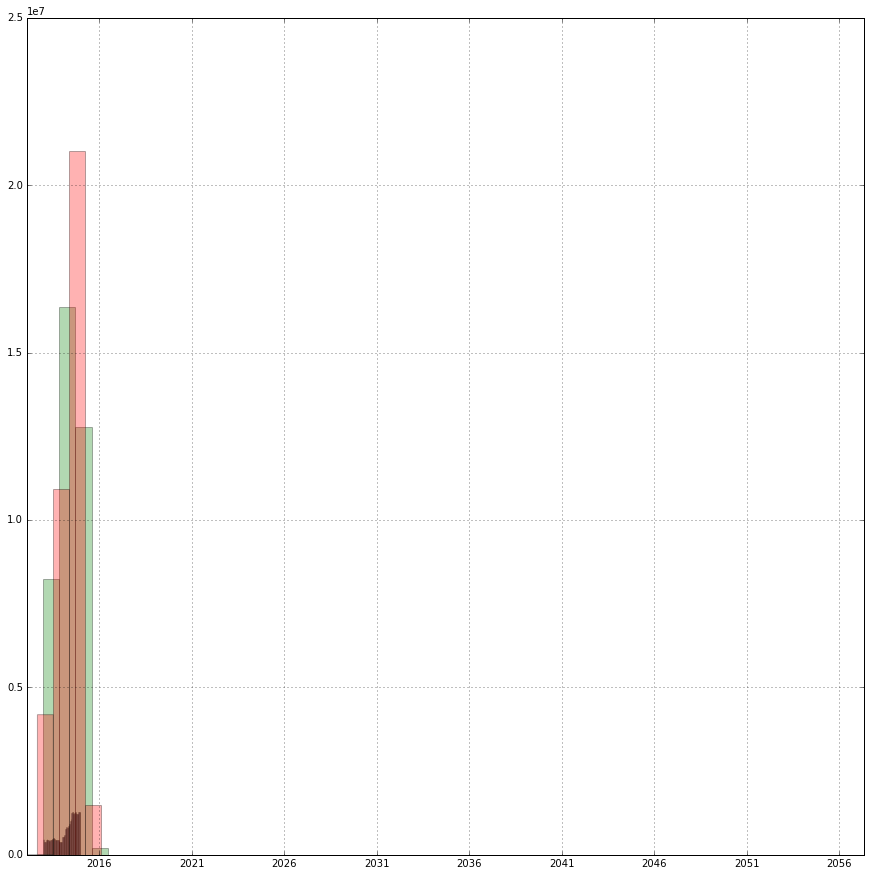

In [7]:
data = train
data["date_time"].hist(bins=52,alpha=.3,figsize=(15,15))
# plt.hist(data["date_time"].values,bins=52,alpha=.3,label = "date_time")
# #plt.hist(data["srch_ci"].values,bins=52,alpha=.3,label = "srch_ci")
# #plt.hist(data["srch_co"].values,bins=52,alpha=.3,label = "srch_co")
data["srch_ci"].hist(bins=52,alpha=.3)
data["srch_co"].hist(bins=52,alpha=.3)

In [7]:
filename = 'test_as_hdf'
test = pd.read_hdf(r"..\expedia_data\{0}.h5".format(filename))
test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2528243 entries, 0 to 2528242
Data columns (total 22 columns):
id                           uint32
date_time                    datetime64[ns]
site_name                    uint8
posa_continent               uint8
user_location_country        uint8
user_location_region         uint16
user_location_city           uint16
orig_destination_distance    float64
user_id                      uint32
is_mobile                    uint8
is_package                   uint8
channel                      uint8
srch_ci                      datetime64[ns]
srch_co                      datetime64[ns]
srch_adults_cnt              uint8
srch_children_cnt            uint8
srch_rm_cnt                  uint8
srch_destination_id          uint32
srch_destination_type_id     uint8
hotel_continent              uint8
hotel_country                uint8
hotel_market                 uint16
dtypes: datetime64[ns](3), float64(1), uint16(3), uint32(3), uint8(12)
memory usag

In [20]:
# save version with no nans in srch_ci, srch_co

train.dropna(axis=0, how='any', subset=["srch_ci","srch_co"], inplace=True)

In [22]:
filename = 'train_date_na_rows_removed'

train.to_csv(r"..\expedia_data\{0}.csv".format(filename) , index=False)

In [26]:
train.to_hdf(r"..\expedia_data\{0}.h5".format(filename),'train',format='fixed',mode='w')


In [25]:
del(train)


GradientBoostingClassifier	 HTML	 KFold	 LinearRegression	 LogisticRegression	 RandomForestClassifier	 SelectKBest	 StandardScaler	 StratifiedKFold	 
a	 chunk	 chunk_pos	 col	 count	 cross_validation	 csv	 csv_chunks	 dataset	 
datasets	 date_columns	 datetime	 datetime_col_errors_dict	 datetime_col_errors_tup	 display	 dtypes_dict	 dtypes_dict_str	 el	 
end	 f	 f_classif	 filename	 gc	 init_type	 missing_date_values	 np	 num_types	 
operator	 output	 pd	 pickle	 plt	 re	 row_id	 start	 started	 
tables	 time	 train	 tup	 w	 


In [8]:
train_bookings_only = train[train.is_booking==True]

In [9]:
len(train_bookings_only)

3000693

In [10]:
filename = 'train_bookings_only'

train_bookings_only.to_csv(r"..\expedia_data\{0}.csv".format(filename) , index=False)

In [11]:
filename = 'train_bookings_only'
train_bookings_only_test  = pd.read_csv( r"..\expedia_data\{0}.csv".format(filename) )
train_bookings_only_test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000693 entries, 0 to 3000692
Data columns (total 24 columns):
date_time                    object
site_name                    int64
posa_continent               int64
user_location_country        int64
user_location_region         int64
user_location_city           int64
orig_destination_distance    float64
user_id                      int64
is_mobile                    int64
is_package                   int64
channel                      int64
srch_ci                      object
srch_co                      object
srch_adults_cnt              int64
srch_children_cnt            int64
srch_rm_cnt                  int64
srch_destination_id          int64
srch_destination_type_id     int64
is_booking                   int64
cnt                          int64
hotel_continent              int64
hotel_country                int64
hotel_market                 int64
hotel_cluster                int64
dtypes: float64(1), int64(20), object(3)
m

In [5]:
import gc
gc.collect()

79